In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

start_period = "2010-01-01"
end_period = "2025-06-01"

ohlc = yf.download(tickers, start=start_period, end=end_period, auto_adjust=True)
prices = ohlc["Close"].dropna(how="all")
prices.tail()


[*********************100%***********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2025-05-23,200.990005,42.946915,1008.500000,109.254097,478.576447,71.263313,312.795959,450.179993,2.67,84.400002
2025-05-27,206.020004,43.960938,1017.789978,111.882889,482.690521,71.273247,313.173828,460.690002,2.70,87.010002
2025-05-28,204.720001,43.801876,1013.140015,111.046448,481.246094,70.647697,311.075714,457.359985,2.65,86.000000
2025-05-29,205.699997,43.980824,1008.739990,111.544327,472.689240,70.985291,310.101227,458.679993,2.56,84.050003
2025-05-30,205.009995,43.871468,1040.180054,112.559998,471.991974,71.590988,312.080017,460.359985,2.65,83.949997


In [2]:
market_prices = yf.download("SPY", start=start_period, end=end_period, auto_adjust=True)["Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2010-01-04,85.515617
2010-01-05,85.741989
2010-01-06,85.802361
2010-01-07,86.164566
2010-01-08,86.451309


In [3]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3893643182080,
 'AMZN': 2288566665216,
 'NAT': 581256512,
 'BAC': 340302462976,
 'DPZ': 15810511872,
 'DIS': 210480578560,
 'KO': 296522842112,
 'MCD': 216937431040,
 'COST': 422529368064,
 'SBUX': 97767571456}

In [4]:
import pypfopt
pypfopt.__version__
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(4.6374833751062985)

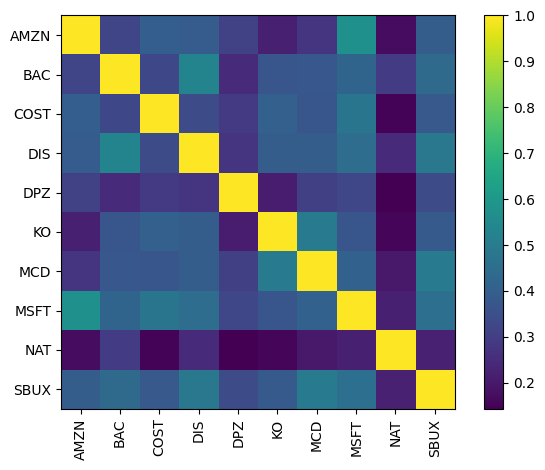

In [5]:
plotting.plot_covariance(S, plot_correlation=True);

In [6]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.285567
BAC     0.177269
COST    0.118268
DIS     0.149617
DPZ     0.119345
KO      0.074415
MCD     0.089177
MSFT    0.245958
NAT     0.132905
SBUX    0.156159
dtype: float64

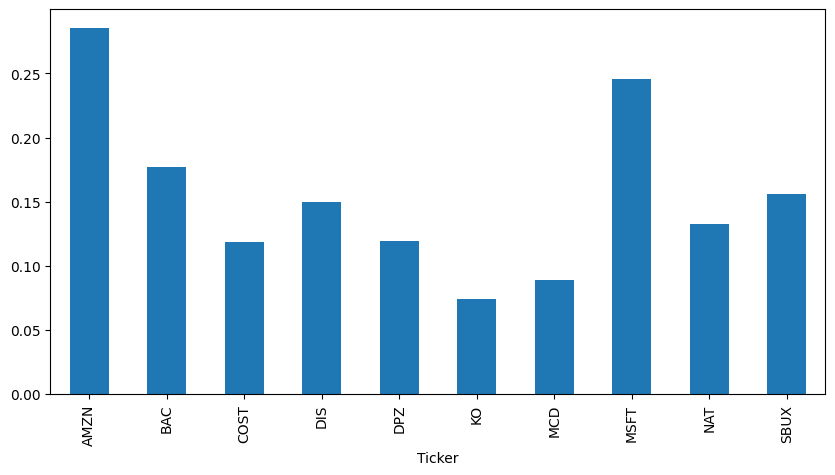

In [7]:
market_prior.plot.bar(figsize=(10,5));

In [8]:
priors_prueba_dict = {"AMZN": 0.05,"BAC": 0.20,"COST": 0.03,"DIS": 0.08,"DPZ": 0.20,"KO": -0.1,"MCD": 0.13,"MSFT": 0.15,"NAT": 0.45,"SBUX": 0.1}
priors_prueba = pd.Series(priors_prueba_dict)

In [9]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=priors_prueba, absolute_views=viewdict)
bl.bl_returns()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: divide by zero encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: overflow encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: invalid value encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: divide by zero encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarnin

Ticker
AMZN    0.067184
BAC     0.244763
COST    0.043432
DIS     0.081085
DPZ     0.204160
KO     -0.075728
MCD     0.144286
MSFT    0.143701
NAT     0.481380
SBUX    0.109148
dtype: float64

In [10]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

# Restricciones generales 

In [11]:
# CVaR, VaR y retorno anualizado
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    if var < 0:
        var = var
    else:
        var = 0
    cvar = (var - (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))) * np.sqrt(365)
    return -cvar

def var_loss(w, S, alpha=0.05):
    """Calcula el Value at Risk (VaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha) * np.sqrt(365)
    if var < 0:
        var = -var
    else:
        var = 0
    return var

def calcular_retorno_anualizado(returns, days=365):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def port_vol(w,cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(365)  # Annualized volatility


#Restricciones de la cartera
def get_portfolio_asset_constraints():
        cons = [
                {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.25},  # At least 25% in equities
                {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.25},  # At least 25% in bonds
                {'type': 'ineq', 'fun': lambda w: w[12:14].sum() - 0.00},  # No lower limit for commodities
                {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
                {'type': 'ineq', 'fun': lambda w: 0.70 - w[6:12].sum()},  # Max 70% in bonds
                {'type': 'ineq', 'fun': lambda w: 0.15 - w[12:14].sum()}   # Max 15% in commodities
        ]
        return cons

def get_asset_maximums(returns_modelos):
    cons = []
    max_weight = 0.15
    for i in range(len(returns_modelos.columns)):
        cons.append({
            'type': 'ineq',
            'fun': lambda w, i=i: max_weight - w[i]
        })

    return cons

# MVO 

In [12]:
from pypfopt import EfficientFrontier, objective_functions

bl = BlackLittermanModel(S, pi=priors_prueba, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
ret = bl.bl_returns()

new_ret = pd.DataFrame([priors_prueba, ret, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T

print(new_ret)




      Prior  Posterior  Views
AMZN   0.05   0.071892   0.10
BAC    0.20   0.237629   0.30
COST   0.03   0.043126   0.05
DIS    0.08   0.081600   0.05
DPZ    0.20   0.202872   0.20
KO    -0.10  -0.066671  -0.05
MCD    0.13   0.147315   0.15
MSFT   0.15   0.144999   0.10
NAT    0.45   0.466554   0.50
SBUX   0.10   0.111385   0.10


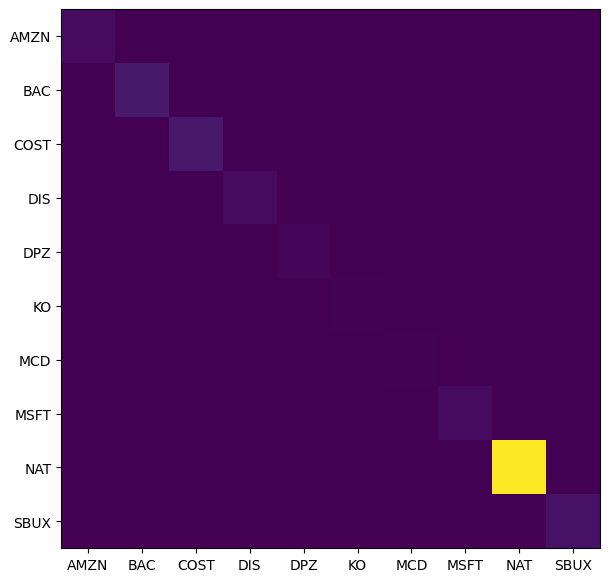

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [75]:
np.diag(bl.omega)

array([0.015625, 0.0225  , 0.015625, 0.005625, 0.0025  , 0.0025  ,
       0.0025  , 0.0004  , 0.16    , 0.0225  ])

In [76]:
#En vez de proveer la confianza nosotros, podemos calcular la matriz de incertidumbre al especificar un invervalo de confianza de 1SD 
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [77]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


# **Posterior estimates**

In [78]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [79]:
# Posterior estimate of returns
retornos_bl = bl.bl_returns()
retornos_bl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: divide by zero encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: overflow encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: invalid value encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T


Ticker
AMZN    0.185465
BAC     0.139542
COST    0.071318
DIS     0.088324
DPZ     0.151886
KO      0.024118
MCD     0.083288
MSFT    0.117396
NAT     0.124349
SBUX    0.112044
dtype: float64

In [80]:
rets_df = pd.DataFrame([market_prior, retornos_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df


,Prior,Posterior,Views
AMZN,0.285567,0.185465,0.10
BAC,0.177269,0.139542,0.30
COST,0.118268,0.071318,0.05
DIS,0.149617,0.088324,0.05
DPZ,0.119345,0.151886,0.20
KO,0.074415,0.024118,-0.05
MCD,0.089177,0.083288,0.15
MSFT,0.245958,0.117396,0.10
NAT,0.132905,0.124349,0.50
SBUX,0.156159,0.112044,0.10


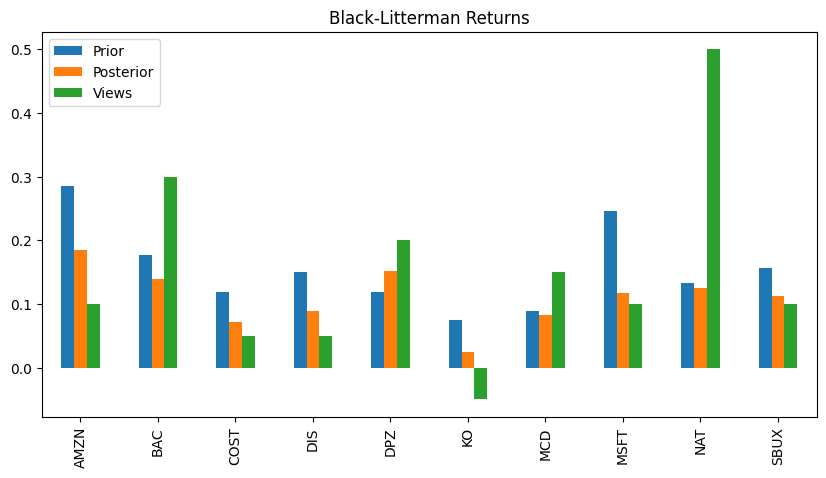

In [81]:
rets_df.plot.bar(figsize=(10,5), title="Black-Litterman Returns", legend=True);

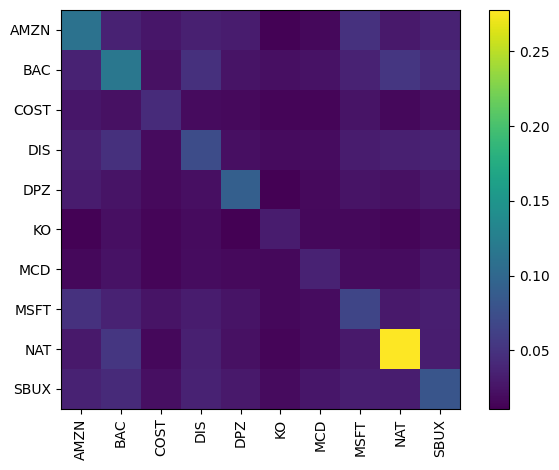

In [82]:
#Se puede usar un procedimiento similar para calcular la matriz de covarianza posterior
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [ ]:
Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1)
P = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)

from pypfopt import EfficientFrontier, objective_functions
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

retornos_bl = bl.bl_returns()
retornos_bl
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

ef = EfficientFrontier(retornos_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
pesos_bl = pd.Series(ef.clean_weights())
pesos_bl

retornos_portafolio_bl = (pesos_bl @ retornos_bl).round(4) * 100  # Convertir a porcentaje
print(f"Retorno del portafolio: {retornos_portafolio_bl}") 

# Portfolio allocation

Retorno del portafolio: 12.870000000000001


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: divide by zero encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: overflow encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: invalid value encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


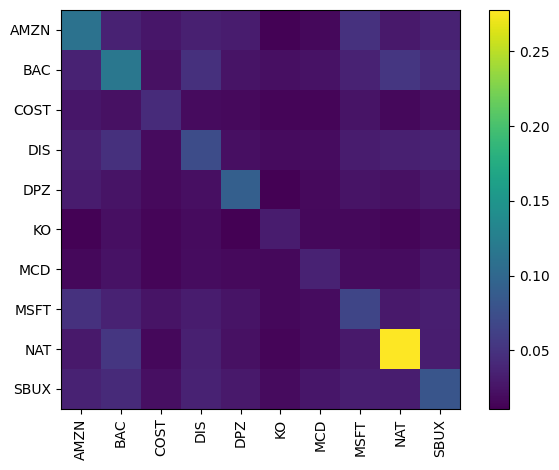

In [ ]:
from pypfopt import EfficientFrontier, objective_functions
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

retornos_bl = bl.bl_returns()
retornos_bl
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

ef = EfficientFrontier(retornos_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
pesos_bl = pd.Series(ef.clean_weights())
pesos_bl

retornos_portafolio_bl = (pesos_bl @ retornos_bl).round(4) * 100  # Convertir a porcentaje
print(f"Retorno del portafolio: {retornos_portafolio_bl}")


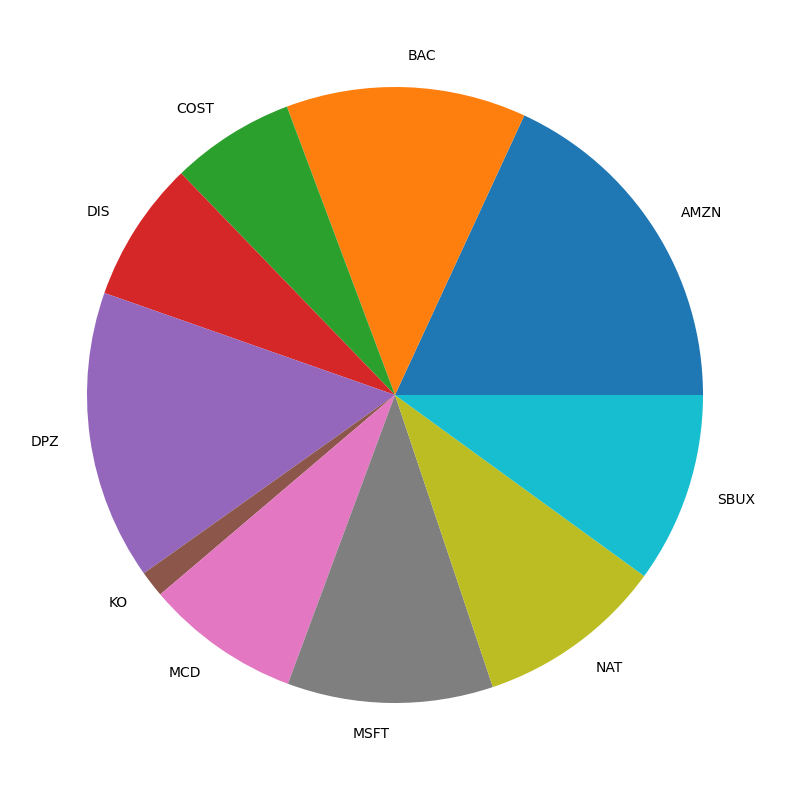

In [85]:
pd.Series(pesos_bl).plot.pie(figsize=(10,10));

In [86]:
import scipy.optimize as sco
from scipy.optimize import minimize

def neg_sharpe_penalizado(w, mu, cov):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(365)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    return -sharpe

def calculate_mvo_weights_lim_cvar_max15():
    bl = BlackLittermanModel(S, pi=priors_prueba, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
    ret = bl.bl_returns()
    df_ret = pd.DataFrame([ret], index=[[market_prices.index[-1]]])

    #Se puede usar un procedimiento similar para calcular la matriz de covarianza posterior
    mu = bl.bl_returns()
    S_bl = bl.bl_cov()
    cov = S_bl.values

    n = len(df_ret.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
    ]
            
    #cons_assets = get_portfolio_asset_constraints()
    #cons.extend(cons_assets)

    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(df_ret)
    cons.extend(cons_assets_max)

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )


    if res.success:
        return pd.Series(res.x, index=df_ret.columns), pd.Series(mu, index=df_ret.columns)    
    else:
        raise ValueError("Optimization failed: " + res.message)
    
pesos_mvo, retornos_mvo = calculate_mvo_weights_lim_cvar_max15()
print(pesos_mvo)
#print(retornos_mvo)

retornos_portafolio_mvo = (pesos_mvo @ retornos_mvo).round(4) * 100  # Convertir a porcentaje
print(f"Retorno del portafolio: {retornos_portafolio_mvo}")


Ticker
AMZN    0.000000
BAC     0.150000
COST    0.139283
DIS     0.008886
DPZ     0.150000
KO      0.000000
MCD     0.150000
MSFT    0.150000
NAT     0.150000
SBUX    0.101831
dtype: float64
Retorno del portafolio: 19.8


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: divide by zero encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: overflow encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: invalid value encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T


# Min var

In [87]:
def calculate_min_var_weight(): 
    bl = BlackLittermanModel(S, pi=priors_prueba, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
    ret = bl.bl_returns()
    df_ret = pd.DataFrame([ret], index=[[market_prices.index[-1]]])

    #Se puede usar un procedimiento similar para calcular la matriz de covarianza posterior
    mu = bl.bl_returns()
    S_bl = bl.bl_cov()
    cov = S_bl.values
    alpha = 0.05  # Nivel de confianza para VaR

    n = len(df_ret.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    # Restricción para los asset class de la cartera 
    #cons_assets = get_portfolio_asset_constraints()
    #cons.extend(cons_assets)

    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(df_ret)
    cons.extend(cons_assets_max)
    
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        var_loss, w0, args=(S, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    
    if res.success:
        return pd.Series(res.x, index=df_ret.columns), pd.Series(mu, index=df_ret.columns)    
    else:
        raise ValueError("Optimization failed: " + res.message)
    
pesos_min_var, retornos_min_var = calculate_min_var_weight()
print(pesos_min_var)
#print(retornos_mvo)

retornos_portafolio_min_var = (pesos_min_var @ retornos_min_var).round(4) * 100  # Convertir a porcentaje
print(f"Retorno del portafolio: {retornos_portafolio_min_var}")

Ticker
AMZN    0.1
BAC     0.1
COST    0.1
DIS     0.1
DPZ     0.1
KO      0.1
MCD     0.1
MSFT    0.1
NAT     0.1
SBUX    0.1
dtype: float64
Retorno del portafolio: 14.41


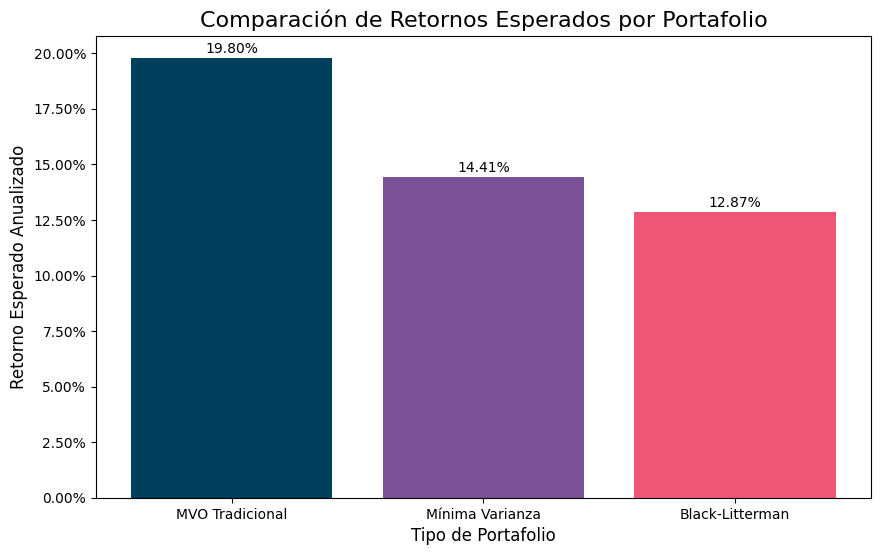

In [94]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_portfolio_returns_bar(returns_dict):
    """
    Crea un gráfico de barras comparando los retornos de diferentes portafolios.
    
    Args:
        returns_dict (dict): Diccionario con nombres de portafolio como claves 
                             y sus retornos (ya en formato porcentaje) como valores.
    """
    labels = list(returns_dict.keys())
    returns = list(returns_dict.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, returns, color=['#003f5c', '#7a5195', '#ef5675'])

    # --- LÍNEA CORREGIDA ---
    # Usa FuncFormatter para añadir el símbolo '%' a los números existentes.
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y:.2f}%'))

    # Añadir títulos y etiquetas
    ax.set_title("Comparación de Retornos Esperados por Portafolio", fontsize=16)
    ax.set_ylabel("Retorno Esperado Anualizado", fontsize=12)
    ax.set_xlabel("Tipo de Portafolio", fontsize=12)
    
    # Añadir el valor sobre cada barra
    for i, v in enumerate(returns):
        ax.text(i, v + 0.1, f"{v:.2f}%", ha='center', va='bottom')

    plt.show()
    return fig, ax

# Ejemplo con datos ya en formato de porcentaje
returns_dict = {
    "MVO Tradicional": retornos_portafolio_mvo, 
    "Mínima Varianza": retornos_portafolio_min_var,
    "Black-Litterman": retornos_portafolio_bl
}

fig, ax = plot_portfolio_returns_bar(returns_dict)

In [ ]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $30.57


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 17,
 'BAC': 58,
 'COST': 1,
 'DIS': 13,
 'DPZ': 7,
 'KO': 4,
 'MCD': 5,
 'MSFT': 5,
 'NAT': 743,
 'SBUX': 24}